In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
ects = pd.read_pickle('data/ec_cts.pk')

In [21]:
ects['CardPlus'] = ects.Prime+ects.TraceFrob+1
ects['CardNeg'] = ects.Prime-ects.TraceFrob+1

## An experiment

How many curves mod $p$ have a point of order 5?

In [38]:
def get_counts(p):
    # We exclude primes q which are congruent to -1,0,1 mod p
    ects0 = ects.loc[ects.Prime**2 %p > 1].loc[ects.CardPlus*ects.CardNeg % p == 0]
    return ects0[['Prime','degree']].groupby('Prime').sum()


In [40]:
smallprimes = [5,7,11,13]
smallprimecountdfs = {p:get_counts(p) for p in smallprimes}

Text(0.5, 1.0, 'Number of curves mod p with a point of order l')

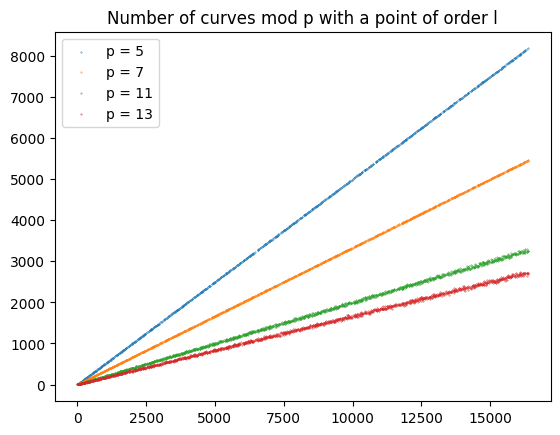

In [55]:
legend = []
for p in smallprimes:
    plt.scatter(x = smallprimecountdfs[p].index, y=smallprimecountdfs[p].values,s=0.1)
    legend.append('p = '+str(p))
plt.legend(legend)
plt.title('Number of curves mod p with a point of order l')

Text(0.5, 1.0, 'Number of curves mod p with a point of order l\n Zoomed In')

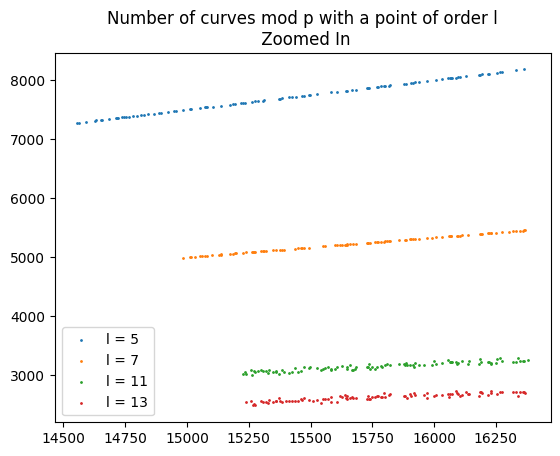

In [54]:
smallprimecountdfs_red = {p:smallprimecountdfs[p].iloc[-100:] for p in smallprimecountdfs}
legend = []
for p in smallprimes:
    plt.scatter(x = smallprimecountdfs_red[p].index, y=smallprimecountdfs_red[p].values,s=1)
    legend.append('l = '+str(p))
plt.legend(legend)
plt.title('Number of curves mod p with a point of order l\n Zoomed In')

## Observations
* Our data looks linear! This is interesting - we are counting the number of curves mod $p$ with cardinality divisible by $\ell$, and it looks like the number depends linearly on $p$. The equation of the line looks like it depends on $\ell$, however.
* This might be harder to notice if you're not looking for it, but the noise increases as $\ell$ gets bigger. There is no noise at all when $\ell = 5, 7$ but there is clearly noise when $\ell > 7$.

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
lr = LinearRegression()

In [82]:
for p in smallprimecountdfs:
    dfp = smallprimecountdfs[p]
    xs = dfp.index.values.reshape(-1,1)
    ys = dfp['degree']
    lr.fit(xs,ys)
    yslin = [y for y in lr.predict(xs)]
    dfp['degree_pred'] = yslin

In [86]:
primesplits = {}
for p in smallprimes:
    dfp = smallprimecountdfs[p]
    primesabove = dfp.loc[dfp.degree>dfp.degree_pred].index.values
    primesbelow = dfp.loc[dfp.degree<dfp.degree_pred].index.values
    primesplits[p]={'above':primesabove,'below':primesbelow}

In [115]:
df0 = smallprimecountdfs[5].iloc[:20]

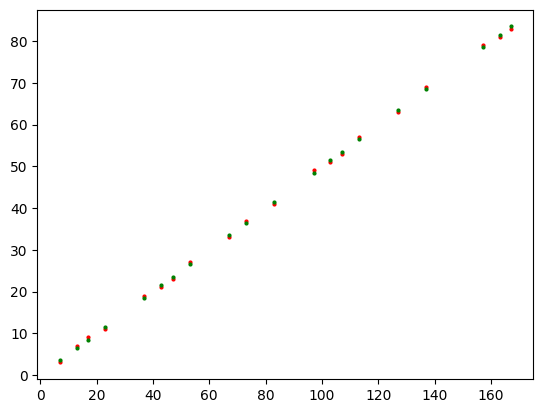

In [120]:
xs = df0.index.values
ys0 = df0['degree'].values
ys1 = df0['degree_pred'].values

plt.scatter(x = xs,y = ys0,c='red',s=4)
plt.scatter(x = xs,y = ys1,c='green',s=4)

In [129]:
def sign_to_redblue(x:float):
    if x > 0:
        return 'red'
    elif x == 0:
        return 'purple'
    else:
        return 'blue'

Text(0.5, 1.0, 'Residuals for l = 5 \n Colored by value of p mod 4')

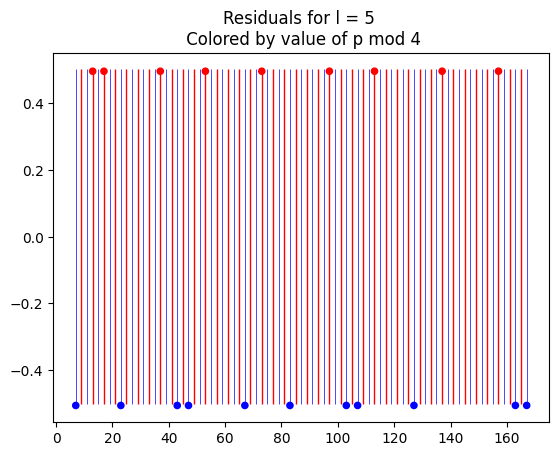

In [132]:
plt.scatter(x = xs,y = ys0-ys1,s=20,c=[sign_to_redblue(d) for d in ys0-ys1])
for x in range(min(xs)-1,max(xs)+2):
    if x % 4 == 1:
        plt.vlines(x=x,ymin=-0.5,ymax = 0.5,color='red',linewidth=1)
    elif x % 4 == 3:
        plt.vlines(x=x,ymin=-0.5,ymax = 0.5,color='blue',linewidth=0.5)
plt.title('Residuals for l = 5 \n Colored by value of p mod 4')


Text(0.5, 1.0, 'Residuals for l = 7 \n Colored by value of p mod 3')

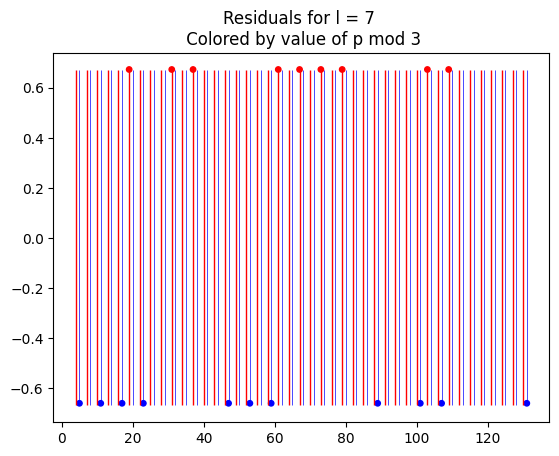

In [136]:
df1 = smallprimecountdfs[7].iloc[:20]
xs1 = df1.index.values
ys01 = df1['degree'].values
ys11 = df1['degree_pred'].values

plt.scatter(x = xs1,y = ys01-ys11,s=15,c=[sign_to_redblue(d) for d in ys01-ys11])
for x in range(min(xs1)-1,max(xs1)+2):
    if x % 3 == 1:
        plt.vlines(x=x,ymin=-0.67,ymax = 0.67,color='red',linewidth=1)
    elif x % 3 == 2:
        plt.vlines(x=x,ymin=-0.67,ymax = 0.67,color='blue',linewidth=0.5)
plt.title('Residuals for l = 7 \n Colored by value of p mod 3')


## What does this mean?

For $\ell = 5, 7$, we have a formula for the number of elliptic curves mod $p$ which is always exactly correct.

The formula is basically a linear function + an error term which is equal to $\pm 1-\frac{1}{n}$, where $n$ is 2 or 3 (depending on whether $\ell = 5$ or 7) and the sign depends on the remainder of $p$ mod 4 or 3. 

This almost makes it seem as if our data is synthetic (which it absolutely is not).
The reason the very abstract question we had has such a nice answer when $\ell = 5, 7$ is because of modular curves.

* For each $\ell$, there is an associated curve called $X_1(\ell)$. When $\ell = 11$, this is an elliptic curve, but in general, the curve is just something that can be described as the zero set of some polynomial $f(x,y)$ with integer coefficients, together with some points at infinity.

* "The number of elliptic curves mod $p$ with a point of order $\ell$" turns out to be just a (scalar multiple) of the number of points on this curve mod $p$.

### Example

The 

In [146]:
def get_pts_x1_5(xrange:tuple,trange:tuple,ep:float):
    x0,xn = xrange
    t0,tn = trange
    pts = []
    t = t0
    while t <= tn:
        x = x0
        while x < xn:
            a = x-t-t*x
            b = x*x*(t-x)
            d = a*a-4*b
            if d == 0:
                pts.append(np.array([x,-a/2,t]))
            elif d > 0:
                ys = np.roots([1,a,b])
                pts+=[np.array([x,y,t]) for y in ys]
            x+=ep
        t+=ep
    return np.array(pts)



In [147]:
ptstest = get_pts_x1_5((-3,3),(-3,18),0.05)

In [151]:
%matplotlib widget 

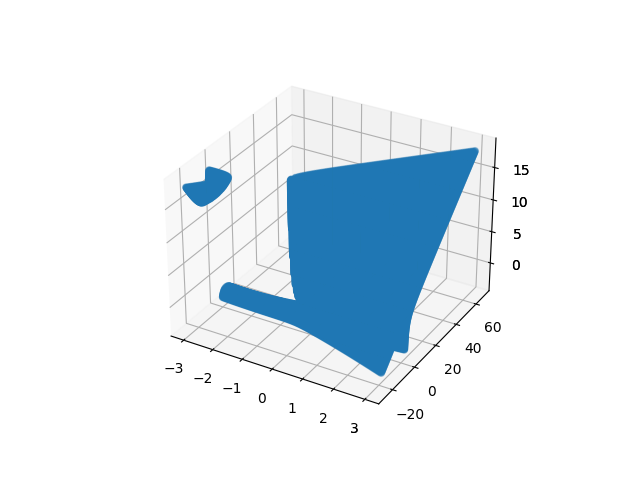

In [154]:
ax = plt.axes(projection ="3d")
ax.scatter3D(xs=ptstest[::,0],ys=ptstest[::,1],zs=ptstest[::,2],alpha=0.3)
plt.show()